# Data ETL Process

This notebook reads the data from two data libraries: a) one with the full transaction history of al Crypto Punk ETFs, and b) another library of image files (.png) for each individual Crypto Punk. 

The ETL process creates 5 tables for the project:

* tx_history_df (Pandas dataframe) 
* traders_df (Pandas dataframe)
* crypto_punks_df (Pandas dataframe)
* categorized_accessories_df (Pandas dataframe)
* machine_learning_df (Pandas dataframe)

These 5 tables are exported as csv files to the folder *"Data"* of this repository.


Note: Please refer to the project ERD for details on the data tables and structures.

In [1]:
# Import Dependencies

import os
import sqlite3 # NOT NEEDED
import requests # NOT NEEDED FOR THE MOMENT
import json

# Import MongoDB libraries for database management 
import pymongo # NOT NEEDED
from pymongo import MongoClient # NOT NEEDED

# Import data manipulation libraries
import numpy as np
import pandas as pd
import random

# Import machine learning libraries
from scipy.optimize import curve_fit #NOT NEEDED FOR THE MOMENT
from scipy.special import zeta # NOT NEEDED FOR THE MOMENT

# Import image and plotting libraries
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


## Read the Data File

In [2]:
# Read the trading data json file
df = pd.read_json("Data/txn_history-2021-10-07.jsonl", lines=True)
df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [3]:
# Inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167492 entries, 0 to 167491
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   txn_type             167492 non-null  object        
 1   from                 167492 non-null  object        
 2   to                   167492 non-null  object        
 3   date                 167492 non-null  datetime64[ns]
 4   timestamp            167492 non-null  datetime64[ns]
 5   source               167492 non-null  object        
 6   eth                  127542 non-null  float64       
 7   punk_id              167492 non-null  int64         
 8   from_wallet_address  419 non-null     object        
 9   to_wallet_address    419 non-null     object        
 10  type                 167492 non-null  object        
 11  accessories          167492 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 15.3

In [4]:
# Make a copy of the df
tx_history_df = df

In [5]:
# Fill "nan" values in the "eth" column with zeroes.
tx_history_df["eth"] = df["eth"].fillna(0)
tx_history_df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address,type,accessories
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None,[Female],"[Green Eye Shadow, Earring, Blonde Bob]"


In [6]:
# Drop unneeded columns
tx_history_df = tx_history_df.drop(columns=["type","accessories"])
tx_history_df.head()

,txn_type,from,to,date,timestamp,source,eth,punk_id,from_wallet_address,to_wallet_address
0,Bid Withdrawn,0xe73a1d,,2021-09-04,2021-09-04,larvalabs,321.0,0,None,None
1,Bid,0xe73a1d,,2021-09-01,2021-09-01,larvalabs,321.0,0,None,None
2,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None
3,Bid,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,320.0,0,None,None
4,Bid Withdrawn,0x2e5e22,,2021-09-01,2021-09-01,larvalabs,263.0,0,None,None


In [7]:
######################################################################
# EXPORT THE DATAFRAME AS A CSV FILE
######################################################################

tx_history_df.to_csv(r'Data/tx_history.csv', index = False)

## Create a Data Table For the Unique Punk IDs and Relevant Features (Type, Accessories)

In [8]:
# Create a copy of the dataframe with only unique values for punk_id
# and the columns describing the characteristics of each individual
# Crypto_punk nft. 
temp_df = df
temp_df = temp_df.drop(columns=['txn_type', 'from', 'to', 'date', 'timestamp', 'source', 'eth', 'from_wallet_address', 'to_wallet_address'])

# Convert the 'type' object to string
temp_df['type'] = temp_df['type'].astype('str')
temp_df['accessories'] = temp_df['accessories'].astype('str')

# Remove the brackets from the 'type'
for row in range(len(temp_df)):
    
    type = temp_df.at[row,'type']
    # index each string to exclude the first two and last two 
    # characters (brackets and quotes)
    clean_type = type[2:-2]
    temp_df.at[row,'type'] = clean_type

crypto_punks_df = temp_df.drop_duplicates()
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
41,1,Male,"['Smile', 'Mohawk']"
104,2,Female,['Wild Hair']
134,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
151,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
167357,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
167364,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
167369,9997,Zombie,"['Front Beard', 'Cap Forward']"
167412,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [9]:
# Reset the index to the same dataframe without adding a new column 
# for the old index information
crypto_punks_df.reset_index(drop=True, inplace=True)
crypto_punks_df

,punk_id,type,accessories
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']"
1,1,Male,"['Smile', 'Mohawk']"
2,2,Female,['Wild Hair']
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']"
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']"
...,...,...,...
9995,9995,Female,"['Purple Eye Shadow', 'Straight Hair Dark']"
9996,9996,Male,"['Cigarette', 'Earring', 'Crazy Hair', 'Smile']"
9997,9997,Zombie,"['Front Beard', 'Cap Forward']"
9998,9998,Female,"['Wild White Hair', 'Black Lipstick', 'Clown E..."


In [10]:
# Inspect the data types
crypto_punks_df.dtypes

punk_id         int64
type           object
accessories    object
dtype: object

In [11]:
# Get a count of the unique Crypto Punk NFT type
print(crypto_punks_df['type'].value_counts())

Male      6039
Female    3840
Zombie      88
Ape         24
Alien        9
Name: type, dtype: int64


## Inspect a Sample of the Image Files

<function matplotlib.pyplot.show(close=None, block=None)>

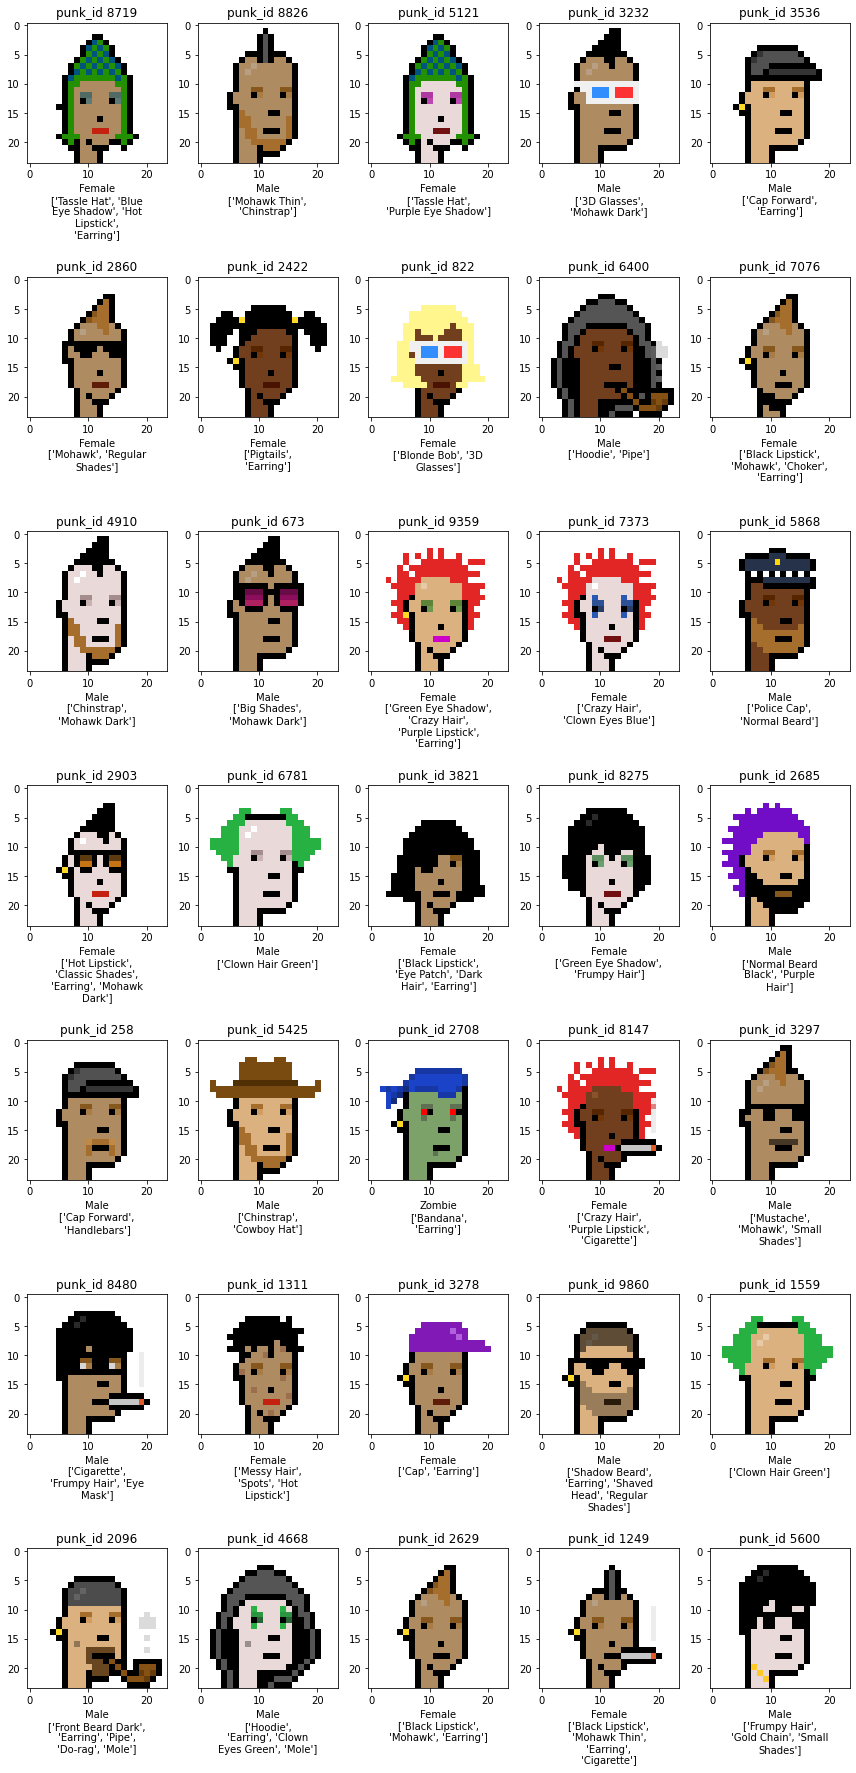

In [12]:
# Inspect a random set of 35 images in a 5 by 7 grid to better
# understand type and accessory features

# create plot
plt.figure(0, figsize=(12,25))

# Initialize variables
cpt = 0
pic_size = 24

# Loop for each row to plot
for n in range(7):

    # Loop for each column to plot
    for i in range(1,6):
        cpt=cpt + 1
        plt.subplot(7,5,cpt)
        
        # Select a random punk image and add it to the plot
        id = random.randint(0,9999)
        file_to_load = ("Data/images/"+str(id)+".png")
        punk_image = Image.open(file_to_load)
        plt.imshow(punk_image)
        plt.title("punk_id "+str(id))
        punk_type = crypto_punks_df.loc[crypto_punks_df["punk_id"] == id,"type"].iloc[0]
        punk_accessories = crypto_punks_df.loc[crypto_punks_df["punk_id"] == id,"accessories"].iloc[0]
        wrapped_label = punk_type+"\n"+("\n".join(wrap(punk_accessories,20)))
        plt.xlabel(wrapped_label)
        
# Show the plotted images   
plt.tight_layout()
plt.show

In [13]:
######################################################################
# EXPORT THE DATAFRAME AS A CSV FILE
######################################################################

crypto_punks_df.to_csv(r'Data/crypto_punks.csv', index = False)

## Create a Data Table for Cataloging the Unique Accessories

In [14]:
# Create a list of the individual accessories
# Capture all individual types and accessories and store them in list

# Create an empty list to hold the data
accessories_list =[]

# Loop through the dataframe
for row in range(len(df)):

    # Add a new field with the count of accessories
    accessory_count = len(df.at[row,"accessories"])
    df.at[row,"accessory_count"]=accessory_count
    
    # Add each new accessory description to a list of unique values
    for i in df.at[row,"accessories"]:
        
        if i not in accessories_list:
            accessories_list.append(i)

# Print all the unique accessories
print("There are "+str(len(accessories_list))+" distinct accessories:\n")
print(accessories_list)

There are 87 distinct accessories:

['Green Eye Shadow', 'Earring', 'Blonde Bob', 'Smile', 'Mohawk', 'Wild Hair', 'Nerd Glasses', 'Pipe', 'Big Shades', 'Goat', 'Purple Eye Shadow', 'Half Shaved', 'Do-rag', 'Wild White Hair', 'Spots', 'Clown Eyes Blue', 'Messy Hair', 'Luxurious Beard', 'Clown Nose', 'Police Cap', 'Big Beard', 'Blue Eye Shadow', 'Black Lipstick', 'Clown Eyes Green', 'Straight Hair Dark', 'Blonde Short', 'Purple Lipstick', 'Straight Hair Blonde', 'Pilot Helmet', 'Hot Lipstick', 'Regular Shades', 'Stringy Hair', 'Small Shades', 'Frown', 'Eye Mask', 'Muttonchops', 'Bandana', 'Horned Rim Glasses', 'Crazy Hair', 'Classic Shades', 'Handlebars', 'Mohawk Dark', 'Dark Hair', 'Peak Spike', 'Normal Beard Black', 'Cap', 'VR', 'Frumpy Hair', 'Cigarette', 'Normal Beard', 'Red Mohawk', 'Shaved Head', 'Chinstrap', 'Mole', 'Knitted Cap', 'Fedora', 'Shadow Beard', 'Straight Hair', 'Hoodie', 'Eye Patch', 'Headband', 'Cowboy Hat', 'Tassle Hat', '3D Glasses', 'Mustache', 'Vape', 'Choker', 'P

In [15]:
# Create a dataframe from the list
accessories_df = pd.DataFrame(accessories_list)
accessories_df

,0
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [16]:
# Assign a header name to the first column
accessories_df.rename(columns={0: "accessory"}, inplace=True)
accessories_df

,accessory
0,Green Eye Shadow
1,Earring
2,Blonde Bob
3,Smile
4,Mohawk
...,...
82,Orange Side
83,Wild Blonde
84,Buck Teeth
85,Top Hat


In [17]:
# Add a new column for count and initialize it to zero
for row in range(len(accessories_df)):
    accessories_df["counts"]=0
    
accessories_df

,accessory,counts
0,Green Eye Shadow,0
1,Earring,0
2,Blonde Bob,0
3,Smile,0
4,Mohawk,0
...,...,...
82,Orange Side,0
83,Wild Blonde,0
84,Buck Teeth,0
85,Top Hat,0


In [18]:
# Loop through the crypto punk id's to establish a count of 
# how often each accessory appears.    
for row in range(len(crypto_punks_df)):

    # read the string of individual accessories
    individual_accessory = crypto_punks_df.at[row,"accessories"]
    
    # clean the string by removing special characters
    characters_to_remove="[']"
    for character in characters_to_remove:
        individual_accessory = individual_accessory.replace(character, "")
    
    # convert the string back to a list
    individual_list = list(individual_accessory.split(", "))
    
    # loop through the individual accessories associated with the punk_id
    for accessory in individual_list:
        
        # look for the index of the accessory in the accessories_df and add to the count
        accessory_index = accessories_df.index[accessories_df['accessory']==accessory]
        accessories_df.at[accessory_index,'counts']=accessories_df.loc[accessory_index,'counts']+1
        
accessories_df

,accessory,counts
0,Green Eye Shadow,271
1,Earring,2459
2,Blonde Bob,147
3,Smile,238
4,Mohawk,441
...,...,...
82,Orange Side,68
83,Wild Blonde,144
84,Buck Teeth,78
85,Top Hat,115


In [19]:
# Sort the counts in descending order
sorted_accessories_df = accessories_df.sort_values(['counts'], ascending=False)
sorted_accessories_df.head(50)

,accessory,counts
1,Earring,2459
48,Cigarette,961
29,Hot Lipstick,696
26,Purple Lipstick,655
53,Mole,644
22,Black Lipstick,617
6,Nerd Glasses,572
37,Horned Rim Glasses,535
8,Big Shades,535
30,Regular Shades,527


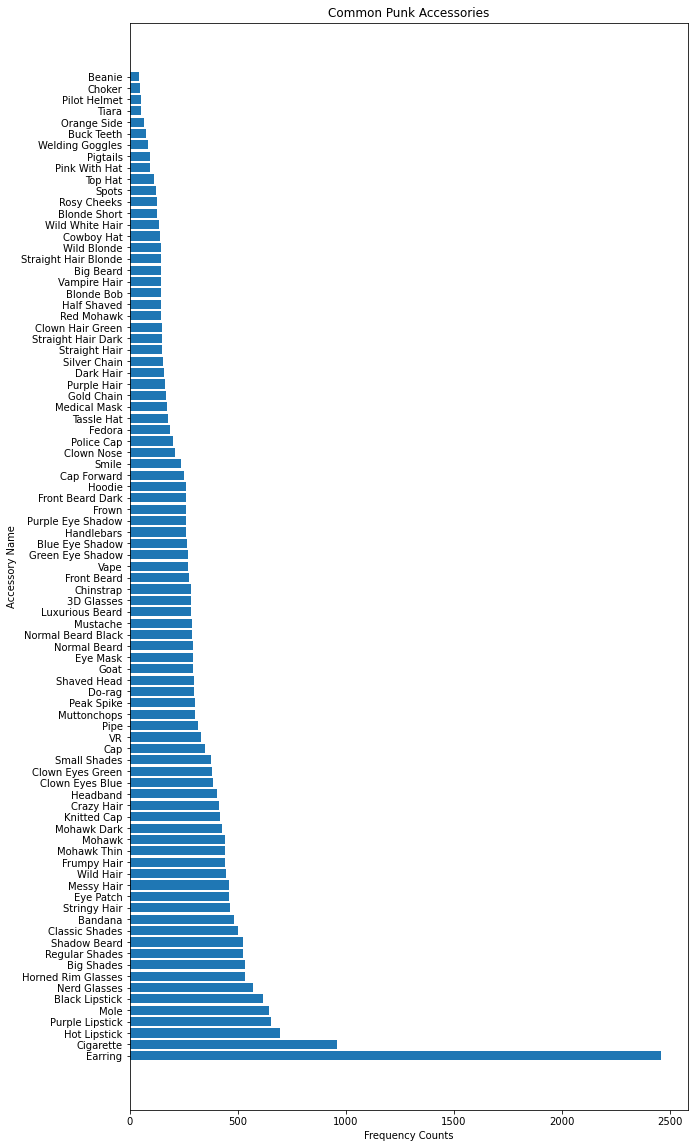

In [20]:
# Plot the frequency of the accessories counts
fig = plt.figure(figsize=(10,20))
plt.barh(sorted_accessories_df['accessory'], sorted_accessories_df['counts'])
plt.title('Common Punk Accessories')
plt.xlabel('Frequency Counts')
plt.ylabel('Accessory Name')
plt.show()

In [21]:
# Export the sorted_accessories_df as a csv for further grouping
# analysis using excel
sorted_accessories_df.to_csv(r"Data/sorted_accessories.csv", index = False)

## Group the Accessories

In [22]:
# After analyzing the data in excel, the accessories were grouped
# into 7 classes: Accessories, Beard, Eyes-Glasses, Hair, Headgear, 
# Mouth and Other.

# Read the csv with the class groupings and convert it to a new
# dataframe
categorized_accessories_df = pd.read_csv("Data/Accessories_class.csv")
categorized_accessories_df

,accessory,counts,class_group1,class_group2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,3D Glasses,286,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bandana,481,Headgear,Headgear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Beanie,44,Headgear,Headgear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Big Beard,146,Beard,Beard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Big Shades,535,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,Welding Goggles,86,Eyes-Glasses,Eyes-Glasses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,Wild Blonde,144,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Wild Hair,447,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Wild White Hair,136,Hair,Hair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Drop the un-needed columns from the excel csv.
categorized_accessories_df = categorized_accessories_df.dropna(axis=1)
categorized_accessories_df

,accessory,counts,class_group1,class_group2
0,3D Glasses,286,Eyes-Glasses,Eyes-Glasses
1,Bandana,481,Headgear,Headgear
2,Beanie,44,Headgear,Headgear
3,Big Beard,146,Beard,Beard
4,Big Shades,535,Eyes-Glasses,Eyes-Glasses
...,...,...,...,...
82,Welding Goggles,86,Eyes-Glasses,Eyes-Glasses
83,Wild Blonde,144,Hair,Hair
84,Wild Hair,447,Hair,Hair
85,Wild White Hair,136,Hair,Hair


In [24]:
# Inspect the two class groupings
categorized_accessories_df.groupby(["class_group1"], as_index=False)["counts"].sum()

,class_group1,counts
0,Accessories,5709
1,Beard,3052
2,Eyes-Glasses,5740
3,Hair,6290
4,Headgear,2936
5,Mouth,2046
6,Other,1766


In [25]:
categorized_accessories_df.groupby(["class_group2"], as_index=False)["counts"].sum()

,class_group2,counts
0,Accessories,4769
1,Beard,3650
2,Eyes-Glasses,6072
3,Hair,6175
4,Headgear,3364
5,Mouth,2046
6,Other,1463


In [26]:
######################################################################
# EXPORT THE DATAFRAME AS A CSV FILE
######################################################################

categorized_accessories_df.to_csv(r'Data/categorized_accessories.csv', index = False)

### Create a Dataframe for Activity by Trader

In [27]:
# Make a copy of the transactions dataframe based on the "from" field
traders1_df = tx_history_df.drop(columns=["to","from_wallet_address","to_wallet_address"])
traders1_df

,txn_type,from,date,timestamp,source,eth,punk_id
0,Bid Withdrawn,0xe73a1d,2021-09-04,2021-09-04,larvalabs,321.00,0
1,Bid,0xe73a1d,2021-09-01,2021-09-01,larvalabs,321.00,0
2,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
3,Bid,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
4,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,263.00,0
...,...,...,...,...,...,...,...
167487,Bid,0xa0a59c,2017-07-03,2017-07-03,larvalabs,0.25,9999
167488,Bid,0x717403,2017-06-26,2017-06-26,larvalabs,0.20,9999
167489,Bid,ddaavvee,2017-06-23,2017-06-23,larvalabs,0.20,9999
167490,Bid,0x5b098b,2017-06-23,2017-06-23,larvalabs,0.15,9999


In [28]:
# drop rows with Nan's in "from"
traders1_df = traders1_df[traders1_df["from"] != ""]
traders1_df

,txn_type,from,date,timestamp,source,eth,punk_id
0,Bid Withdrawn,0xe73a1d,2021-09-04,2021-09-04,larvalabs,321.00,0
1,Bid,0xe73a1d,2021-09-01,2021-09-01,larvalabs,321.00,0
2,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
3,Bid,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
4,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,263.00,0
...,...,...,...,...,...,...,...
167486,Bid,0x7760e0,2017-07-03,2017-07-03,larvalabs,0.25,9999
167487,Bid,0xa0a59c,2017-07-03,2017-07-03,larvalabs,0.25,9999
167488,Bid,0x717403,2017-06-26,2017-06-26,larvalabs,0.20,9999
167489,Bid,ddaavvee,2017-06-23,2017-06-23,larvalabs,0.20,9999


In [29]:
# Rename "from" column
traders1_df.rename(columns = {'from':'trader_id'}, inplace = True)
traders1_df

/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,txn_type,trader_id,date,timestamp,source,eth,punk_id
0,Bid Withdrawn,0xe73a1d,2021-09-04,2021-09-04,larvalabs,321.00,0
1,Bid,0xe73a1d,2021-09-01,2021-09-01,larvalabs,321.00,0
2,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
3,Bid,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.00,0
4,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,263.00,0
...,...,...,...,...,...,...,...
167486,Bid,0x7760e0,2017-07-03,2017-07-03,larvalabs,0.25,9999
167487,Bid,0xa0a59c,2017-07-03,2017-07-03,larvalabs,0.25,9999
167488,Bid,0x717403,2017-06-26,2017-06-26,larvalabs,0.20,9999
167489,Bid,ddaavvee,2017-06-23,2017-06-23,larvalabs,0.20,9999


In [30]:
# Inpsect the unique transaction types
traders1_df.txn_type.value_counts()

Bid                26808
Sold               18979
Bid Withdrawn      16342
Transfer           14225
(Wrap)              2773
(Unwrap)            2526
Offered             1526
Offer Withdrawn      469
Name: txn_type, dtype: int64

In [31]:
# Make a second copy of the transactions dataframe based on the "to" field
traders2_df = tx_history_df.drop(columns=["from","from_wallet_address","to_wallet_address"])
traders2_df

,txn_type,to,date,timestamp,source,eth,punk_id
0,Bid Withdrawn,,2021-09-04,2021-09-04,larvalabs,321.00,0
1,Bid,,2021-09-01,2021-09-01,larvalabs,321.00,0
2,Bid Withdrawn,,2021-09-01,2021-09-01,larvalabs,320.00,0
3,Bid,,2021-09-01,2021-09-01,larvalabs,320.00,0
4,Bid Withdrawn,,2021-09-01,2021-09-01,larvalabs,263.00,0
...,...,...,...,...,...,...,...
167487,Bid,,2017-07-03,2017-07-03,larvalabs,0.25,9999
167488,Bid,,2017-06-26,2017-06-26,larvalabs,0.20,9999
167489,Bid,,2017-06-23,2017-06-23,larvalabs,0.20,9999
167490,Bid,,2017-06-23,2017-06-23,larvalabs,0.15,9999


In [32]:
# drop rows with Nan's in "to"
traders2_df = traders2_df[traders2_df["to"] != ""]
traders2_df

,txn_type,to,date,timestamp,source,eth,punk_id
22,Sold,0xe08c32,2018-11-30,2018-11-30,larvalabs,25.00,0
29,Transfer,0xf5099e,2017-07-07,2017-07-07,larvalabs,0.00,0
30,Sold,0xa0a59c,2017-07-07,2017-07-07,larvalabs,1.60,0
37,Sold,0x00d7c9,2017-06-23,2017-06-23,larvalabs,0.98,0
40,Claimed,0xc352b5,2017-06-23,2017-06-23,larvalabs,0.00,0
...,...,...,...,...,...,...,...
167433,Sold,0xcfd9cc,2021-03-03,2021-03-03,larvalabs,38.00,9998
167437,Sold,TokenAng…,2020-12-27,2020-12-27,larvalabs,15.00,9998
167439,Claimed,cyberpnk…,2017-06-23,2017-06-23,larvalabs,0.00,9998
167457,Transfer,punk9999…,2017-07-19,2017-07-19,larvalabs,0.00,9999


In [33]:
# Rename "to" column
traders2_df.rename(columns = {'to':'trader_id'}, inplace = True)
traders2_df

/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,txn_type,trader_id,date,timestamp,source,eth,punk_id
22,Sold,0xe08c32,2018-11-30,2018-11-30,larvalabs,25.00,0
29,Transfer,0xf5099e,2017-07-07,2017-07-07,larvalabs,0.00,0
30,Sold,0xa0a59c,2017-07-07,2017-07-07,larvalabs,1.60,0
37,Sold,0x00d7c9,2017-06-23,2017-06-23,larvalabs,0.98,0
40,Claimed,0xc352b5,2017-06-23,2017-06-23,larvalabs,0.00,0
...,...,...,...,...,...,...,...
167433,Sold,0xcfd9cc,2021-03-03,2021-03-03,larvalabs,38.00,9998
167437,Sold,TokenAng…,2020-12-27,2020-12-27,larvalabs,15.00,9998
167439,Claimed,cyberpnk…,2017-06-23,2017-06-23,larvalabs,0.00,9998
167457,Transfer,punk9999…,2017-07-19,2017-07-19,larvalabs,0.00,9999


In [34]:
# Inspect the unique transaction types
traders2_df.txn_type.value_counts()

Sold        18979
Transfer    13835
Claimed     10000
(Wrap)       2773
(Unwrap)     2526
Offered       765
Name: txn_type, dtype: int64

In [35]:
# Replace the transaction types to reflect the perspective of the 
# counterparty to the transaction
traders2_df['txn_type'].replace(
    to_replace=['Sold','Transfer','Offered'], 
    value=['Purchased','Received','Offer Received'],
    inplace=True)
traders2_df

/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,txn_type,trader_id,date,timestamp,source,eth,punk_id
22,Purchased,0xe08c32,2018-11-30,2018-11-30,larvalabs,25.00,0
29,Received,0xf5099e,2017-07-07,2017-07-07,larvalabs,0.00,0
30,Purchased,0xa0a59c,2017-07-07,2017-07-07,larvalabs,1.60,0
37,Purchased,0x00d7c9,2017-06-23,2017-06-23,larvalabs,0.98,0
40,Claimed,0xc352b5,2017-06-23,2017-06-23,larvalabs,0.00,0
...,...,...,...,...,...,...,...
167433,Purchased,0xcfd9cc,2021-03-03,2021-03-03,larvalabs,38.00,9998
167437,Purchased,TokenAng…,2020-12-27,2020-12-27,larvalabs,15.00,9998
167439,Claimed,cyberpnk…,2017-06-23,2017-06-23,larvalabs,0.00,9998
167457,Received,punk9999…,2017-07-19,2017-07-19,larvalabs,0.00,9999


In [36]:
# Re-inspect the unique transaction types
traders2_df.txn_type.value_counts()

Purchased         18979
Received          13835
Claimed           10000
(Wrap)             2773
(Unwrap)           2526
Offer Received      765
Name: txn_type, dtype: int64

In [37]:
# Merge the two trader dataframes
traders_df = pd.concat([traders1_df,traders2_df])
traders_df

,txn_type,trader_id,date,timestamp,source,eth,punk_id
0,Bid Withdrawn,0xe73a1d,2021-09-04,2021-09-04,larvalabs,321.0,0
1,Bid,0xe73a1d,2021-09-01,2021-09-01,larvalabs,321.0,0
2,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.0,0
3,Bid,0x2e5e22,2021-09-01,2021-09-01,larvalabs,320.0,0
4,Bid Withdrawn,0x2e5e22,2021-09-01,2021-09-01,larvalabs,263.0,0
...,...,...,...,...,...,...,...
167433,Purchased,0xcfd9cc,2021-03-03,2021-03-03,larvalabs,38.0,9998
167437,Purchased,TokenAng…,2020-12-27,2020-12-27,larvalabs,15.0,9998
167439,Claimed,cyberpnk…,2017-06-23,2017-06-23,larvalabs,0.0,9998
167457,Received,punk9999…,2017-07-19,2017-07-19,larvalabs,0.0,9999


In [38]:
# Sort the dataframe by trader and date
traders_df = traders_df.sort_values(['trader_id', 'date'],
              ascending = [True, True])
traders_df

,txn_type,trader_id,date,timestamp,source,eth,punk_id
4950,Bid,007,2019-12-17,2019-12-17,larvalabs,0.10,521
4949,Bid Withdrawn,007,2020-01-02,2020-01-02,larvalabs,0.10,521
126547,Purchased,007,2020-04-07,2020-04-07,larvalabs,0.70,7750
126545,Sold,007,2020-04-08,2020-04-08,larvalabs,0.85,7750
160412,Bid,0age.eth,2021-06-09,2021-06-09,larvalabs,12.34,9626
...,...,...,...,...,...,...,...
118768,Bid,🤹🏻‍♂.e…,2021-09-07,2021-09-07,larvalabs,89.00,7334
118764,Bid Withdrawn,🤹🏻‍♂.e…,2021-09-08,2021-09-08,larvalabs,111.00,7334
118765,Bid,🤹🏻‍♂.e…,2021-09-08,2021-09-08,larvalabs,111.00,7334
51870,Purchased,🦊🦄👩‍?…,2021-07-31,2021-07-31,larvalabs,32.00,3520


In [39]:
# Reset the index
traders_df.reset_index(drop=False, inplace=True)
traders_df

,index,txn_type,trader_id,date,timestamp,source,eth,punk_id
0,4950,Bid,007,2019-12-17,2019-12-17,larvalabs,0.10,521
1,4949,Bid Withdrawn,007,2020-01-02,2020-01-02,larvalabs,0.10,521
2,126547,Purchased,007,2020-04-07,2020-04-07,larvalabs,0.70,7750
3,126545,Sold,007,2020-04-08,2020-04-08,larvalabs,0.85,7750
4,160412,Bid,0age.eth,2021-06-09,2021-06-09,larvalabs,12.34,9626
...,...,...,...,...,...,...,...,...
132521,118768,Bid,🤹🏻‍♂.e…,2021-09-07,2021-09-07,larvalabs,89.00,7334
132522,118764,Bid Withdrawn,🤹🏻‍♂.e…,2021-09-08,2021-09-08,larvalabs,111.00,7334
132523,118765,Bid,🤹🏻‍♂.e…,2021-09-08,2021-09-08,larvalabs,111.00,7334
132524,51870,Purchased,🦊🦄👩‍?…,2021-07-31,2021-07-31,larvalabs,32.00,3520


In [40]:
# Reorder the columns
traders_df = traders_df[['index', 'trader_id', 'txn_type', 'punk_id', 'eth', 'date','timestamp','source']]
traders_df

,index,trader_id,txn_type,punk_id,eth,date,timestamp,source
0,4950,007,Bid,521,0.10,2019-12-17,2019-12-17,larvalabs
1,4949,007,Bid Withdrawn,521,0.10,2020-01-02,2020-01-02,larvalabs
2,126547,007,Purchased,7750,0.70,2020-04-07,2020-04-07,larvalabs
3,126545,007,Sold,7750,0.85,2020-04-08,2020-04-08,larvalabs
4,160412,0age.eth,Bid,9626,12.34,2021-06-09,2021-06-09,larvalabs
...,...,...,...,...,...,...,...,...
132521,118768,🤹🏻‍♂.e…,Bid,7334,89.00,2021-09-07,2021-09-07,larvalabs
132522,118764,🤹🏻‍♂.e…,Bid Withdrawn,7334,111.00,2021-09-08,2021-09-08,larvalabs
132523,118765,🤹🏻‍♂.e…,Bid,7334,111.00,2021-09-08,2021-09-08,larvalabs
132524,51870,🦊🦄👩‍?…,Purchased,3520,32.00,2021-07-31,2021-07-31,larvalabs


In [41]:
######################################################################
# EXPORT THE DATAFRAME AS A CSV FILE
######################################################################

traders_df.to_csv(r'Data/traders.csv', index = False)

## Decide on the Target Data 

In [42]:
#####################################################################
##
##  Based on the distribution of "Type" and "Accessories" field 
##  values we decided on two options for our target data:
##
##     Option 1: predict the "type", from either "Male", "Female" or 
##               "Other", where "Other" groups "Zombie", "Ape" and
##               "Alien" types.
##
##     Option 2: predict whether the image has glasses, where the
##               "accessories" field includes any of the values
##               "3D Glasses", "Big Shades", "Classic Shades", 
##               "Eye Mask", Horned Rim Glasses", "Nerd Glasses", 
##               "Regular Shades", "Small Shades", "VR" or "Welding 
##               Goggles".
##
#####################################################################

In [43]:
# Create a list for the glasses accessories
glasses = ["3D Glasses", 
           "Big Shades", 
           "Classic Shades",
           "Eye Mask",
           "Horned Rim Glasses",
           "Nerd Glasses", 
           "Regular Shades", 
           "Small Shades", 
           "VR",
           "Welding Goggles"]

In [44]:
# Inspect the data types again
crypto_punks_df.dtypes

punk_id         int64
type           object
accessories    object
dtype: object

In [45]:
# Make a copy of the crypto_punks_df for machine learning
machine_learning_df = crypto_punks_df

In [46]:
# Loop through the machine_learning_df dataframe and
# assign values to the target fields

for row in range(len(machine_learning_df)):
    
    # In a new column, "type_ML", assign a numerical value to
    # the type: set Male = 0, Female = 1 and 
    # Other(Zombie/Ape/Alien) = 2
    
    if machine_learning_df.loc[row,"type"] == "Male":
        machine_learning_df.loc[row,"type_ML"] = 0
    elif machine_learning_df.loc[row,"type"] == "Female":
        machine_learning_df.loc[row,"type_ML"] = 1
    else:
        machine_learning_df.loc[row,"type_ML"] = 2

    # Determine if the accessories include any glasses
    # 1. Get the accessories for the given punk_id
    punk_accessories = machine_learning_df.loc[row,"accessories"]
    
    # 2. Assign a value of 0 to a new column names "glasses_ML"
    #    to indicate the punk_id currently has no glasses
    machine_learning_df.loc[row,"glasses_ML"] = 0
    
    # 2. Loop trough the list of possible glasses
    for glass in glasses:
        
        # 3. If already found glasses, stop checking
        if (machine_learning_df.loc[row,"glasses_ML"] == 0):
        
            # 4. if the accessories include any of the glasses
            #    indicate a 1 in the column "glasses_ML"
            if glass in punk_accessories:
                machine_learning_df.loc[row,"glasses_ML"] = 1
            
machine_learning_df.head(5)

/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/ignacioguerra/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,punk_id,type,accessories,type_ML,glasses_ML
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']",1.0,0.0
1,1,Male,"['Smile', 'Mohawk']",0.0,0.0
2,2,Female,['Wild Hair'],1.0,0.0
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']",0.0,1.0
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']",0.0,1.0


In [47]:
# Change the ML data types to integer
machine_learning_df = machine_learning_df.astype({"type_ML": int,"glasses_ML": int})
machine_learning_df.head()

,punk_id,type,accessories,type_ML,glasses_ML
0,0,Female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']",1,0
1,1,Male,"['Smile', 'Mohawk']",0,0
2,2,Female,['Wild Hair'],1,0
3,3,Male,"['Wild Hair', 'Nerd Glasses', 'Pipe']",0,1
4,4,Male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']",0,1


In [48]:
# Inspect the crypto_punks_df by "type_ML"
machine_learning_df.groupby(["type_ML"], as_index=False)["punk_id"].count()

,type_ML,punk_id
0,0,6039
1,1,3840
2,2,121


In [49]:
# Inspect the crypto_punks_df by "glasses_ML"
machine_learning_df.groupby(["glasses_ML"], as_index=False)["punk_id"].count()

,glasses_ML,punk_id
0,0,5954
1,1,4046


In [50]:
######################################################################
# EXPORT THE DATAFRAME AS A CSV FILE
######################################################################

machine_learning_df.to_csv(r'Data/machine_learning.csv', index = False)

## Create Classification Tables

In [51]:
# Create a list for the target type classifications
type_classification_df = pd.DataFrame(
           {"type_ML" : [0,1,2],
            "type_class" : ["Male","Female","Other"]},
         index = [0, 1, 2])
type_classification_df

,type_ML,type_class
0,0,Male
1,1,Female
2,2,Other


In [52]:
# Create a list for the target type classifications
glasses_classification_df = pd.DataFrame(
           {"glasses_ML" : [0,1],
            "glasses_class" : ["No Glasses","Has Glasses"]},
         index = [0, 1])
glasses_classification_df

,glasses_ML,glasses_class
0,0,No Glasses
1,1,Has Glasses


In [53]:
######################################################################
# EXPORT THE DATAFRAMES AS A CSV FILES
######################################################################

type_classification_df.to_csv(r'Data/type_classification.csv', index = False)

In [54]:
glasses_classification_df.to_csv(r'Data/glasses_classification.csv', index = False)

# END